# Implementar o Conditional GAN

- Usar Conditional GAN: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) com o dataset criado a partir de um grafo causal implícito

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
index = pd.read_csv('~/ml/Hackday/shap_busca/data/data_new.csv')

In [3]:
index = index[['classification','price','vip']]

In [4]:
index.head()

,classification,price,vip
0,0,4.5,235.0
1,0,7.4,192.0
2,0,7.4,192.0
3,1,49.0,814.0
4,0,49.0,814.0


In [5]:
index.shape

(499068, 3)

In [6]:
index[['price','vip']].quantile([0.9,0.95,0.99])

,price,vip
0.90,170.0,480.0
0.95,250.0,679.0
0.99,450.0,1115.0


In [7]:
price_lim, vip_lim = index[['price','vip']].quantile(0.9).values
# add_cart_lim = index['add_cart'].quantile(0.99)

In [8]:
index = index[index['price']<=price_lim]
index = index[index['vip']<=vip_lim]
# index = index[index['add_cart']<=add_cart_lim]

In [9]:
index.shape

(407278, 3)

In [10]:
index = index.sample(n=100000)

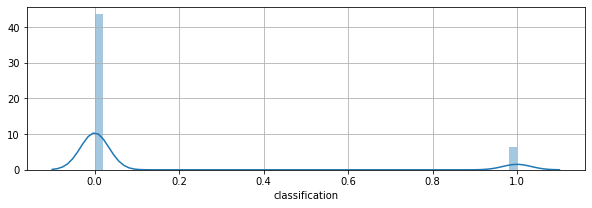

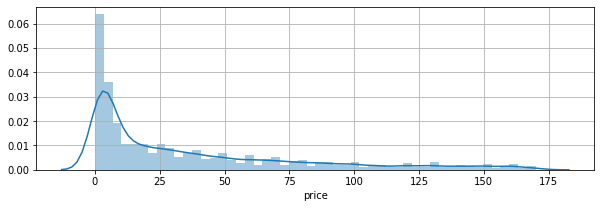

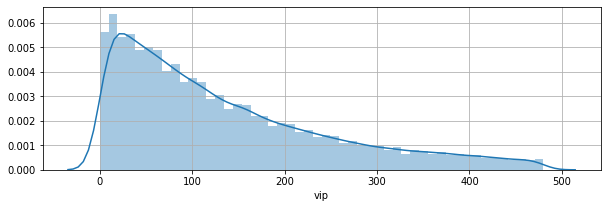

In [11]:
for col in index.columns:
    plt.figure(figsize=(10,3))
    sns.distplot(index[col])
    plt.grid(True)
    plt.show()

---
### Funções de auxílio

In [12]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D fake')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

def gan_summary(df_num,rho):
    oh = np.eye(2)
    batch = X_tc.shape[0]
    l_s = np.random.choice([0,1],p=[1-rho,rho],size=(batch))
    l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
    l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

    z = noise(batch,Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    g = G(z,w,l_s_)
    g = torch.Tensor(scaler.inverse_transform(g.cpu().data.numpy())).type(torch.FloatTensor).cuda()
    x_gen = torch.cat((l_s,g),dim=1)

    df_g = pd.DataFrame(data=x_gen.cpu().data.numpy(),columns=df_num.columns)

    df_g['vip'] = np.round(df_g['vip'].values,0)
    df_g['classification'] = np.round(df_g['classification'].values,0)
#     df_g['add_cart'] = np.round(df_g['add_cart'].values,0)
    df_g['price'] = np.round(df_g['price'].values,2)
    
    df_g['Expected_income'] = df_g['vip'] * df_g['price']
    df_num['Expected_income'] = df_num['vip'] * df_num['price']

    #dataset fake
    print("Fake total expected income: {:.2f}\n".format(df_g['Expected_income'].sum()),df_g[['price','vip','Expected_income']].describe().loc[['mean','std','25%','50%','75%']])

    #dataset real
    print("Real total expected income: {:.2f}\n".format(df_num['Expected_income'].sum()),df_num.describe()[['price','vip','Expected_income']].loc[['mean','std','25%','50%','75%']])

    for col in ['price','vip','Expected_income']:
        plt.figure(figsize=(10,3))
        sns.distplot(df_num[col],label='Real')
        sns.distplot(df_g[col],label='Fake')
        plt.legend(loc=0)
        plt.grid(True)
        plt.show()
    
    df_g.drop('Expected_income',axis=1,inplace=True)
    df_num.drop('Expected_income',axis=1,inplace=True)

def noise(dim0,dim1):
    return Variable(Normal(loc=0, scale=5).sample(sample_shape=torch.Size([dim0,dim1])))

def noise_uniform(dim0,dim1):
    return Variable(Uniform(-5,5).sample(sample_shape=torch.Size([dim0,dim1])))

---

## ConditionalGAN

- Label: usaremos apenas um label, `bigode`.
- Gerador: receberá o ruído `z` e a label `y` e retornará o dado `G(z,y)`.
- Discriminador: receberá `G(z,y)` e `z` e retornará a probabilidade do dado ser real.

In [13]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from torch.distributions import Uniform
from torch.distributions.normal import Normal
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
df_num = index.copy()

In [15]:
# probabilidade de ocorre bigode=1 no dataset
rho = df_num[df_num["classification"]==1].shape[0]/df_num.shape[0]
rho

0.12915

In [16]:
X_data = df_num.drop("classification",axis=1).copy().values
scaler.fit(X_data)
X_data = scaler.transform(X_data)
y_data = pd.get_dummies(df_num["classification"]).values.reshape(X_data.shape[0],2)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
y_tc = torch.Tensor(y_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([100000, 2]) torch.FloatTensor torch.Size([100000, 2]) torch.FloatTensor


In [33]:
Z_dim,W_dim,h_dim,X_dim,y_dim = [50,50,100,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden = torch.nn.Linear(Z_dim+W_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,w,l):
        h = F.relu(self.hidden(torch.cat((z,w,l),dim=1)))
        h = nn.Dropout(p=0.7)(h)
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X,l):
        h = F.relu(self.hidden(torch.cat((X,l),dim=1)))
        h = nn.Dropout(p=0.7)(h)
        y = torch.sigmoid(self.out(h))
        return y

In [34]:
# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()

# Definimos os otimizadores
lrg,lrd = [1e-5,1e-5]
G_optim = optim.Adam(G.parameters(),lr=lrg,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrg*0.,amsgrad=False)
D_optim = optim.Adam(D.parameters(),lr=lrd,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrd*0.,amsgrad=False)

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    
batch = X_tc.shape[0]
ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()
D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()

def nets_test(n_sample,G,D):
    z = noise(n_sample,Z_dim).cuda()
    w = noise_uniform(n_sample,W_dim).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g = G(z,w,l)
    D_real = D(x,l)
    D_fake = D(g,l)
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))
    
G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his] 

In [35]:
#load saved networks
G.load_state_dict(torch.load('models/g_cond_gan_products.pt'))
D.load_state_dict(torch.load('models/d_cond_gan_products.pt'))

In [36]:
%%time
epochs = 5000

for epoch in range(epochs):
    # Amostragem de dados
    z = noise(batch,Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    X = X_tc.cuda()
    l = y_tc.cuda()
    # Dicriminador
    G_sample = G(z,w,l)
    D_real = D(X,l)
    D_fake = D(G_sample,l)
    D_loss_real = D_loss_real_func(D_real, ones)
    D_loss_fake = D_loss_fake_func(D_fake, zeros)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_optim.step()
    reset_grad()
    # Generador
    z = noise(batch,Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    G_sample = G(z,w,l)
    D_fake = D(G_sample,l)
    G_loss = G_loss_func(D_fake, ones)
    G_loss.backward()
    G_optim.step()
    reset_grad()
    # Recolher dados das funções de perda
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/4) == 0 and epoch > 0:
        print('Epoch-{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}| Average D_real: {:.5f} | Average D_fake: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data))
        nets_test(30000,G,D)

Epoch-1250| Average D_loss: 1.40909| Average G_loss: 0.71533| Average D_real: 0.71930 | Average D_fake: 0.68979
Average D_real  0.492126| Std D_real  0.068402
Average D_fake  0.493700| Std D_fake  0.066934
Epoch-2500| Average D_loss: 1.39979| Average G_loss: 0.69327| Average D_real: 0.69446 | Average D_fake: 0.70533
Average D_real  0.502466| Std D_real  0.056018
Average D_fake  0.502057| Std D_fake  0.054198
Epoch-3750| Average D_loss: 1.39640| Average G_loss: 0.69633| Average D_real: 0.69713 | Average D_fake: 0.69927
Average D_real  0.500684| Std D_real  0.048409
Average D_fake  0.500232| Std D_fake  0.048069
CPU times: user 1h 26min 54s, sys: 37.6 s, total: 1h 27min 31s
Wall time: 14min 39s


In [37]:
nets_test(50000,G,D)

Average D_real  0.498817| Std D_real  0.039548
Average D_fake  0.498177| Std D_fake  0.039645


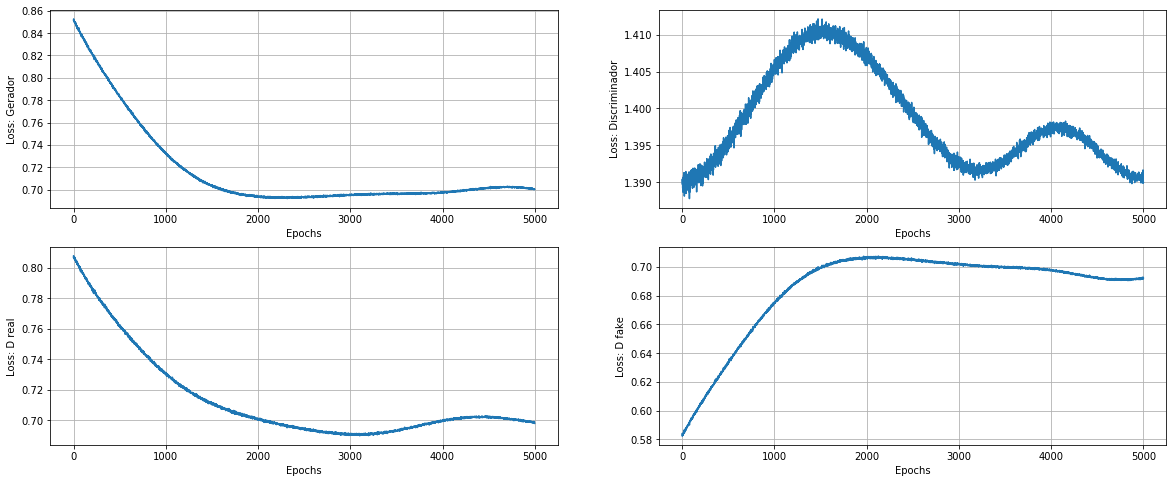

In [38]:
plot_losses(losses_his)

In [44]:
#save networks
# torch.save(G.state_dict(), 'models/g_cond_gan_products.pt')
# torch.save(D.state_dict(), 'models/d_cond_gan_products.pt')

### Reproduzindo mais dados como os do dataset inicial

In [40]:
rho

0.12915

Fake total expected income: 493045376.00
           price         vip  Expected_income
mean  49.753094  136.633194      4930.453613
std   45.467609  121.451553      6629.988770
25%   11.300000   33.000000       670.320007
50%   34.730000  100.000000      2344.114990
75%   79.419998  216.000000      6453.344971
Real total expected income: 494892591.60
           price         vip  Expected_income
mean  37.100129  135.112670      4948.925916
std   42.739373  114.500669      8978.364808
25%    4.000000   44.000000       330.720000
50%   19.900000  102.000000      1325.500000
75%   57.200000  197.000000      5140.800000


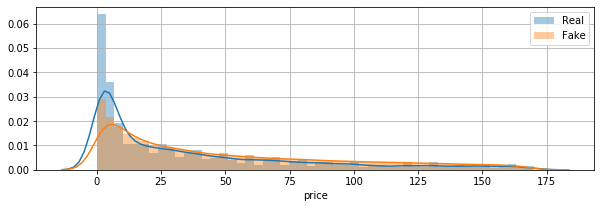

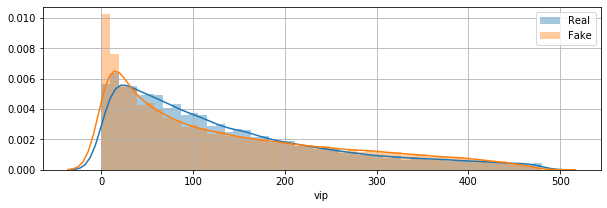

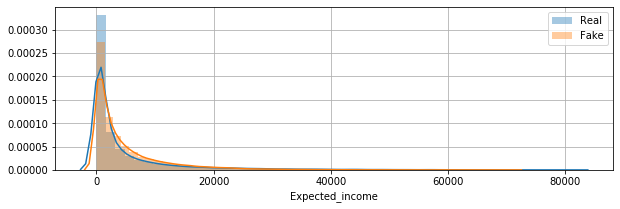

In [41]:
gan_summary(df_num, rho=rho)

### Intervenção

Fake total expected income: 488064832.00
           price         vip  Expected_income
mean  49.498573  136.684341      4880.648438
std   45.407185  121.744583      6540.137207
25%   11.400000   33.000000       662.652481
50%   34.400002  100.000000      2325.025024
75%   78.622501  217.000000      6439.605103
Real total expected income: 494892591.60
           price         vip  Expected_income
mean  37.100129  135.112670      4948.925916
std   42.739373  114.500669      8978.364808
25%    4.000000   44.000000       330.720000
50%   19.900000  102.000000      1325.500000
75%   57.200000  197.000000      5140.800000


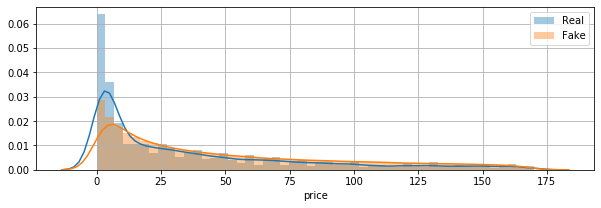

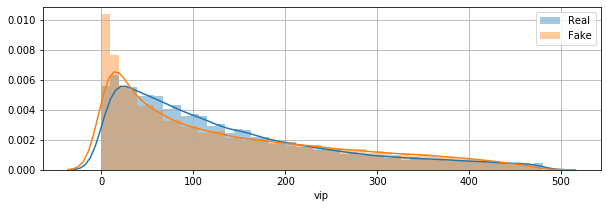

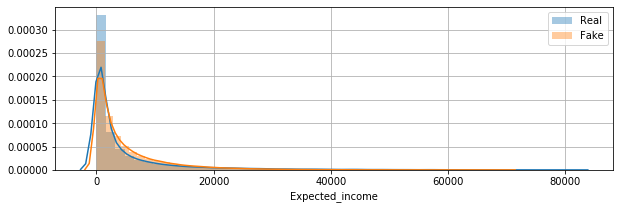

In [46]:
gan_summary(df_num, rho=0.05)